In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
from fastai.tabular.all import *
from pathlib import Path

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [16]:
path = Path('input/competitions/playground-series-s6e2/')

In [21]:
path

Path('input/competitions/playground-series-s6e2')

In [17]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.60,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.00,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.00,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.00,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.80,2,3,3,Presence


In [18]:
cat_cols = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 
            'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium','Heart Disease']

for col in cat_cols:
    df[col] = df[col].astype('category')

df.dtypes

id                            int64
Age                           int64
Sex                        category
Chest pain type            category
BP                            int64
Cholesterol                   int64
FBS over 120               category
EKG results                category
Max HR                        int64
Exercise angina            category
ST depression               float64
Slope of ST                category
Number of vessels fluro    category
Thallium                   category
Heart Disease              category
dtype: object

In [31]:
df.columns

Index(['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
       'Heart Disease'],
      dtype='str')

In [19]:
df['Heart Disease'].value_counts()/len(df)

Heart Disease
Absence    0.55
Presence   0.45
Name: count, dtype: float64

In [20]:
import numpy as np

df.describe(include=(np.number))

,id,Age,BP,Cholesterol,Max HR,ST depression
count,630000.00,630000.00,630000.00,630000.00,630000.00,630000.00
mean,314999.50,54.14,130.50,245.01,152.82,0.72
std,181865.48,8.26,14.98,33.68,19.11,0.95
min,0.00,29.00,94.00,126.00,71.00,0.00
25%,157499.75,48.00,120.00,223.00,142.00,0.00
50%,314999.50,54.00,130.00,243.00,157.00,0.10
75%,472499.25,60.00,140.00,269.00,166.00,1.40
max,629999.00,77.00,200.00,564.00,202.00,6.20


In [21]:
df.isna().sum()

id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [22]:
def summarize_categorical(df, target=None):
    cat_cols = df.select_dtypes(include="category").columns
    summaries = []

    for col in cat_cols:
        vc = df[col].value_counts(dropna=False)
        top = vc.index[0]
        freq = vc.iloc[0]
        nunique = df[col].nunique(dropna=False)
        missing = df[col].isna().mean()

        # Round percentages to 2 decimals
        value_pct = {k: round(v, 2) for k, v in (vc / len(df)).to_dict().items()}

        row = {
            "column": col,
            "nunique": nunique,
            "top": top,
            "freq": freq,
            "missing_pct": round(missing, 2),
            "value_distribution": vc.to_dict(),
            "value_pct_distribution": value_pct,
            "unique_values": list(vc.index),  # actual object values
        }

        if target is not None:
            row["target_mean_by_top"] = round(df[df[col] == top][target].mean(), 2)
            row["target_mean_by_value"] = {k: round(v, 2) for k, v in df.groupby(col, dropna=False)[target].mean().to_dict().items()}

        summaries.append(row)

    return pd.DataFrame(summaries)


In [11]:
df.select_dtypes(include="category").columns

Index(['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
       'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
       'Heart Disease'],
      dtype='str')

In [12]:
summarize_categorical(df)

,column,nunique,top,freq,missing_pct,value_distribution,value_pct_distribution,unique_values
0,Sex,2,1,450283,0.00,"{1: 450283, 0: 179717}","{1: 0.71, 0: 0.29}","[1, 0]"
1,Chest pain type,4,4,329179,0.00,"{4: 329179, 3: 197278, 2: 74941, 1: 28602}","{4: 0.52, 3: 0.31, 2: 0.12, 1: 0.05}","[4, 3, 2, 1]"
2,FBS over 120,2,0,579608,0.00,"{0: 579608, 1: 50392}","{0: 0.92, 1: 0.08}","[0, 1]"
3,EKG results,3,0,320116,0.00,"{0: 320116, 2: 308562, 1: 1322}","{0: 0.51, 2: 0.49, 1: 0.0}","[0, 2, 1]"
4,Exercise angina,2,0,457553,0.00,"{0: 457553, 1: 172447}","{0: 0.73, 1: 0.27}","[0, 1]"
5,Slope of ST,3,1,358293,0.00,"{1: 358293, 2: 256215, 3: 15492}","{1: 0.57, 2: 0.41, 3: 0.02}","[1, 2, 3]"
6,Number of vessels fluro,4,0,445862,0.00,"{0: 445862, 1: 106978, 2: 54303, 3: 22857}","{0: 0.71, 1: 0.17, 2: 0.09, 3: 0.04}","[0, 1, 2, 3]"
7,Thallium,3,3,372286,0.00,"{3: 372286, 7: 246748, 6: 10966}","{3: 0.59, 7: 0.39, 6: 0.02}","[3, 7, 6]"
8,Heart Disease,2,Absence,347546,0.00,"{'Absence': 347546, 'Presence': 282454}","{'Absence': 0.55, 'Presence': 0.45}","[Absence, Presence]"


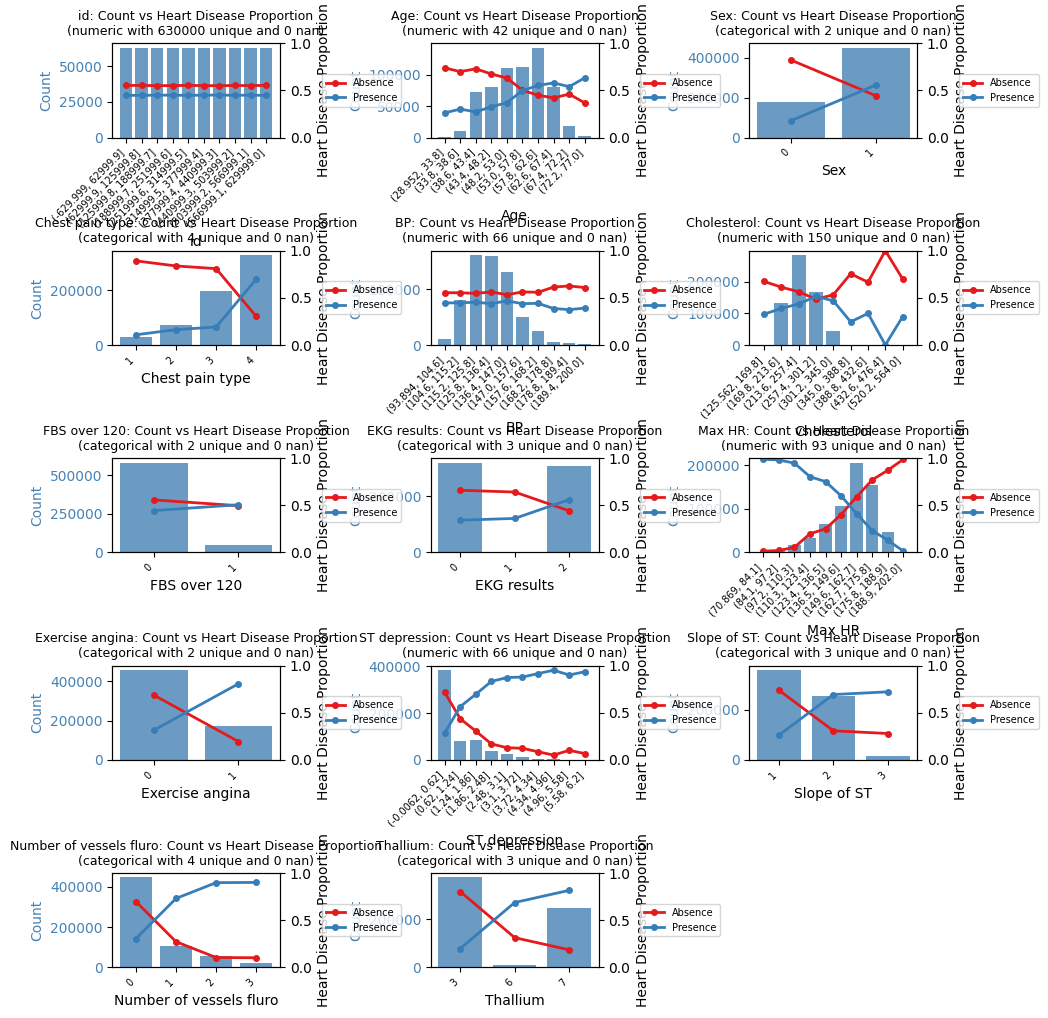

In [23]:
def plot_feature_vs_target(df, target_col=None, figsize=(14, 12), n_cols=3, bins=10, target_type='auto'):
    """
    Plot count distribution and optionally mean target value for each feature.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing features and optionally target
    target_col : str or None
        Name of the target column (e.g., 'exam_score'). 
        If None, only plots count distribution (for test data).
    figsize : tuple
        Figure size (width, height)
    n_cols : int
        Number of columns in subplot grid
    bins : int
        Number of bins for numeric features with many unique values
    target_type : str
        'auto', 'numeric', or 'categorical'. If 'auto', infers from data.
    """
    # Determine features to plot
    if target_col is not None:
        features = [col for col in df.columns if col != target_col]
    else:
        features = list(df.columns)
    
    # Determine target type
    if target_col is not None:
        if target_type == 'auto':
            if pd.api.types.is_numeric_dtype(df[target_col]) and df[target_col].nunique() > 10:
                target_type = 'numeric'
            else:
                target_type = 'categorical'
    
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        
        n_unique = df[feature].nunique()
        n_nan = df[feature].isna().sum()
        
        # Determine if numeric or categorical
        is_numeric = pd.api.types.is_numeric_dtype(df[feature])
        
        if is_numeric and n_unique > 15:
            # Bin numeric features with many unique values
            df_temp = df[[feature]].dropna()
            df_temp['binned'] = pd.cut(df_temp[feature], bins=bins)
            grouped = df_temp.groupby('binned', observed=True).agg(
                count=(feature, 'size')
            ).reset_index()
            grouped['label'] = grouped['binned'].astype(str)
            feature_type = f"numeric with {n_unique} unique"
            
            # Add target stats if available
            if target_col is not None:
                df_with_target = df[[feature, target_col]].dropna()
                df_with_target['binned'] = pd.cut(df_with_target[feature], bins=bins)
                if target_type == 'numeric':
                    target_grouped = df_with_target.groupby('binned', observed=True).agg(
                        mean_target=(target_col, 'mean')
                    ).reset_index()
                    grouped = grouped.merge(target_grouped, on='binned', how='left')
                else:
                    # For categorical: compute proportion of each target class
                    target_grouped = df_with_target.groupby('binned', observed=True)[target_col].value_counts(normalize=True).unstack(fill_value=0)
                    target_grouped = target_grouped.reset_index()
                    grouped = grouped.merge(target_grouped, on='binned', how='left')
        else:
            # Categorical or numeric with few unique values
            grouped = df.groupby(feature, dropna=False).size().reset_index(name='count')
            grouped['label'] = grouped[feature].astype(str)
            feature_type = f"categorical with {n_unique} unique" if not is_numeric else f"numeric with {n_unique} unique"
            
            # Add target stats if available
            if target_col is not None:
                if target_type == 'numeric':
                    target_grouped = df.groupby(feature, dropna=False)[target_col].mean().reset_index()
                    target_grouped.columns = [feature, 'mean_target']
                    grouped = grouped.merge(target_grouped, on=feature, how='left')
                else:
                    target_grouped = df.groupby(feature, dropna=False)[target_col].value_counts(normalize=True).unstack(fill_value=0)
                    target_grouped = target_grouped.reset_index()
                    grouped = grouped.merge(target_grouped, on=feature, how='left')
        
        # Plot bar chart for counts
        x_pos = range(len(grouped))
        ax1.bar(x_pos, grouped['count'], color='steelblue', alpha=0.8)
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Count', color='steelblue')
        ax1.tick_params(axis='y', labelcolor='steelblue')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(grouped['label'], rotation=45, ha='right', fontsize=7)
        
        # Create secondary y-axis for target ONLY if target_col is provided
        if target_col is not None:
            ax2 = ax1.twinx()
            if target_type == 'numeric':
                ax2.plot(x_pos, grouped['mean_target'], color='orange', marker='o', 
                         linewidth=2, markersize=6)
                ax2.set_ylabel(f'Mean {target_col}', color='orange')
                ax2.tick_params(axis='y', labelcolor='orange')
                title_suffix = f'Count vs Mean {target_col}'
            else:
                # Plot proportion lines for each target class
                target_classes = [c for c in grouped.columns if c not in ['count', 'label', feature, 'binned']]
                colors = plt.cm.Set1(range(len(target_classes)))
                for i, cls in enumerate(target_classes):
                    ax2.plot(x_pos, grouped[cls], marker='o', linewidth=2, markersize=4, 
                             color=colors[i], label=str(cls))
                ax2.set_ylabel(f'{target_col} Proportion', color='black')
                ax2.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), borderaxespad=0, fontsize=7, frameon=True)
                ax2.set_ylim(0, 1)
                title_suffix = f'Count vs {target_col} Proportion'
        else:
            title_suffix = 'Count Distribution'
        
        # Title with feature info
        ax1.set_title(f'{feature}: {title_suffix}\n({feature_type} and {n_nan} nan)', 
                      fontsize=9)
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    fig.subplots_adjust(hspace=1.2, wspace=0.9, right=0.7)
    plt.show()
    
    return fig


f = plot_feature_vs_target(df, target_col='Heart Disease', target_type='categorical')

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _cramers_v(x, y):
    # Cramer's V for categorical-categorical
    confusion = pd.crosstab(x, y)
    if confusion.size == 0:
        return np.nan
    chi2 = scipy.stats.chi2_contingency(confusion, correction=False)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    if n == 0:
        return np.nan
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1) or 1)))

def _correlation_ratio(categories, measurements):
    # Correlation ratio (eta) for categorical-numeric
    cat = pd.Series(categories).astype('category')
    meas = pd.Series(measurements)
    if meas.nunique() <= 1:
        return np.nan
    groups = [meas[cat == c] for c in cat.cat.categories]
    n = sum(len(g) for g in groups)
    if n == 0:
        return np.nan
    grand_mean = meas.mean()
    ss_between = sum(len(g) * (g.mean() - grand_mean) ** 2 for g in groups if len(g) > 0)
    ss_total = ((meas - grand_mean) ** 2).sum()
    if ss_total == 0:
        return np.nan
    return np.sqrt(ss_between / ss_total)

def plot_feature_associations(df, figsize=(12, 10), method='spearman', cat_threshold=15):
    """
    Plot association matrices between independent variables (numeric/categorical/mixed).
    - Numeric vs Numeric: correlation (method)
    - Categorical vs Categorical: Cramer's V
    - Numeric vs Categorical: correlation ratio (eta)
    """
    cols = list(df.columns)
    n = len(cols)
    assoc = pd.DataFrame(np.nan, index=cols, columns=cols)

    def is_categorical(s):
        return (s.dtype == 'object') or (s.dtype == 'category') or (s.nunique(dropna=True) <= cat_threshold)

    for i, col_i in enumerate(cols):
        for j, col_j in enumerate(cols):
            if i > j:
                continue
            x = df[col_i]
            y = df[col_j]

            cat_i = is_categorical(x)
            cat_j = is_categorical(y)

            if i == j:
                assoc.iloc[i, j] = 1.0
            elif not cat_i and not cat_j:
                # numeric-numeric
                assoc.iloc[i, j] = x.corr(y, method=method)
                assoc.iloc[j, i] = assoc.iloc[i, j]
            elif cat_i and cat_j:
                # categorical-categorical
                assoc.iloc[i, j] = _cramers_v(x, y)
                assoc.iloc[j, i] = assoc.iloc[i, j]
            else:
                # mixed
                if cat_i:
                    assoc.iloc[i, j] = _correlation_ratio(x, y)
                else:
                    assoc.iloc[i, j] = _correlation_ratio(y, x)
                assoc.iloc[j, i] = assoc.iloc[i, j]

    # Heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(assoc, vmin=0, vmax=1, cmap='viridis', square=True, cbar_kws={'label': 'Association Strength'})
    plt.title('Feature Association Matrix (mixed types)')
    plt.tight_layout()
    plt.show()

    return assoc


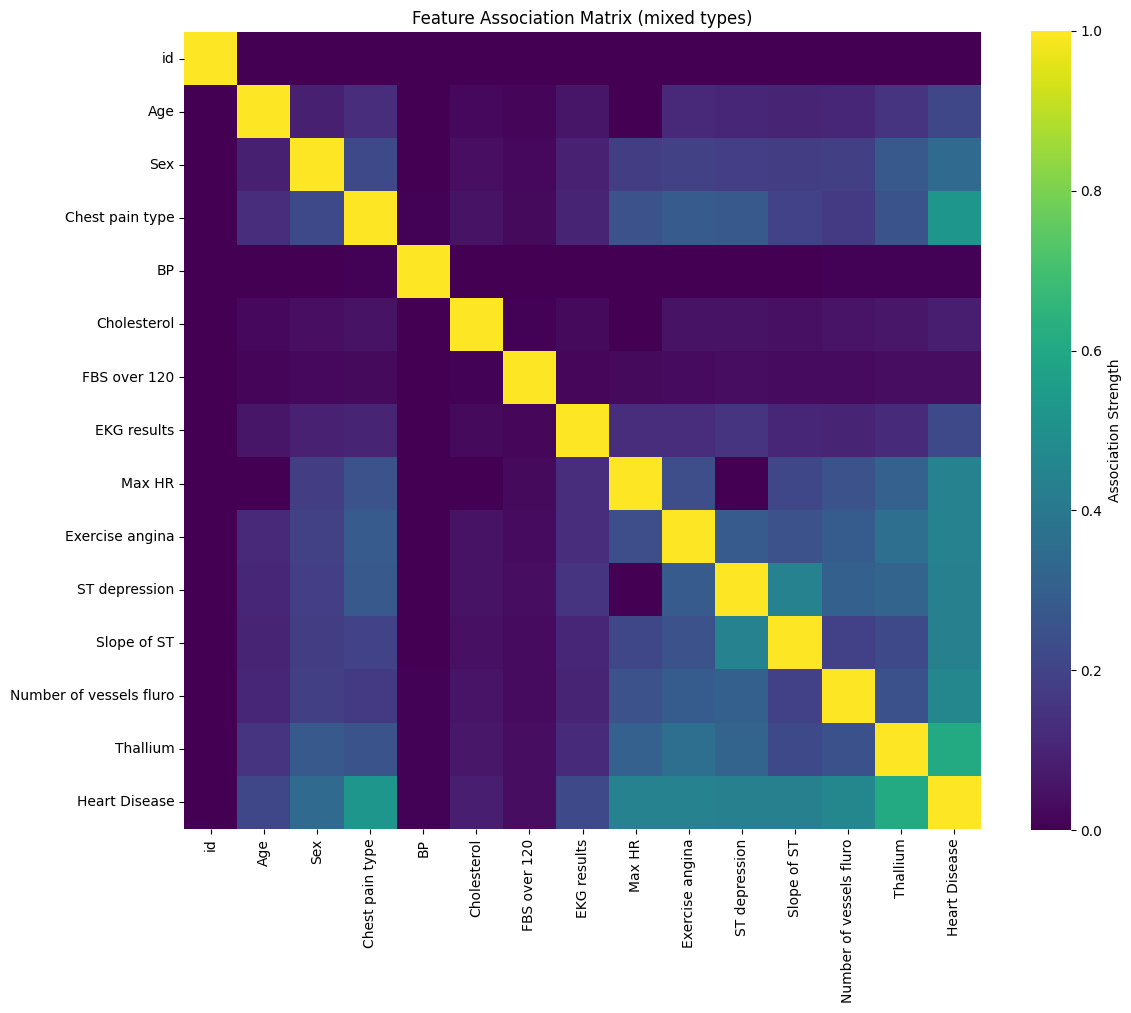

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,1.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00
Age,0.00,1.00,0.09,0.13,-0.00,0.02,0.01,0.06,-0.10,0.11,0.11,0.10,0.11,0.15,0.21
Sex,0.00,0.09,1.00,0.22,0.00,0.04,0.02,0.09,0.18,0.19,0.18,0.18,0.19,0.28,0.34
Chest pain type,0.00,0.13,0.22,1.00,0.01,0.05,0.03,0.10,0.25,0.28,0.27,0.20,0.17,0.26,0.53
BP,-0.00,-0.00,0.00,0.01,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.01,0.01
Cholesterol,-0.00,0.02,0.04,0.05,-0.00,1.00,0.01,0.02,-0.05,0.05,0.05,0.04,0.05,0.06,0.08
FBS over 120,0.00,0.01,0.02,0.03,0.00,0.01,1.00,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03
EKG results,0.00,0.06,0.09,0.10,0.00,0.02,0.02,1.00,0.13,0.13,0.15,0.11,0.10,0.12,0.22
Max HR,-0.00,-0.10,0.18,0.25,0.00,-0.05,0.02,0.13,1.00,0.24,-0.23,0.21,0.25,0.31,0.44
Exercise angina,0.00,0.11,0.19,0.28,0.00,0.05,0.03,0.13,0.24,1.00,0.28,0.25,0.29,0.36,0.44


In [27]:
plot_feature_associations(df)

In [17]:
FEATURES = list( df.columns[1:-1] )
print(f"There are {len(FEATURES)} features:")
print(FEATURES)

There are 13 features:
['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


In [28]:
df.dtypes

id                            int64
Age                           int64
Sex                        category
Chest pain type            category
BP                            int64
Cholesterol                   int64
FBS over 120               category
EKG results                category
Max HR                        int64
Exercise angina            category
ST depression               float64
Slope of ST                category
Number of vessels fluro    category
Thallium                   category
Heart Disease              category
dtype: object

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


In [ ]:
df.isna().sum()

In [ ]:

df.describe(include=(np.number))

In [ ]:
df.columns

In [ ]:
df.select_dtypes(include='number').columns


In [ ]:
df.select_dtypes(include='object').columns


In [31]:
df.dtypes

id                            int64
Age                           int64
Sex                        category
Chest pain type            category
BP                            int64
Cholesterol                   int64
FBS over 120               category
EKG results                category
Max HR                        int64
Exercise angina            category
ST depression               float64
Slope of ST                category
Number of vessels fluro    category
Thallium                   category
Heart Disease              category
dtype: object

In [32]:
df.select_dtypes(include='category').columns

Index(['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
       'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
       'Heart Disease'],
      dtype='str')

## simple logistic regression baseline

In [69]:
from sklearn.model_selection import train_test_split                                      
from sklearn.linear_model import LogisticRegression                                     
from sklearn.preprocessing import OneHotEncoder, StandardScaler                           
from sklearn.compose import ColumnTransformer                                           
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

cat_cols = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
            'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']    
cont_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

X = df[cat_cols + cont_cols]
y = df['Heart Disease']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
random_state=42, stratify=y)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), cont_cols),
])

model = Pipeline([
    ('prep', preprocessor),
    ('lr', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

In [71]:

# Get probabilities
train_probs = model.predict_proba(X_train)[:,1]
val_probs = model.predict_proba(X_valid)[:,1]

# Evaluate
print(f"Train Accuracy: {accuracy_score(y_train, model.predict(X_train)):.4f}")
print(f"Val Accuracy: {accuracy_score(y_valid, model.predict(X_valid)):.4f}")
print(f"Train ROC-AUC: {roc_auc_score(y_train, train_probs):.4f}")
print(f"Val ROC-AUC: {roc_auc_score(y_valid, val_probs):.4f}")

Train Accuracy: 0.8852
Val Accuracy: 0.8870
Train ROC-AUC: 0.9527
Val ROC-AUC: 0.9537


In [72]:
model.classes_

array(['Absence', 'Presence'], dtype=object)

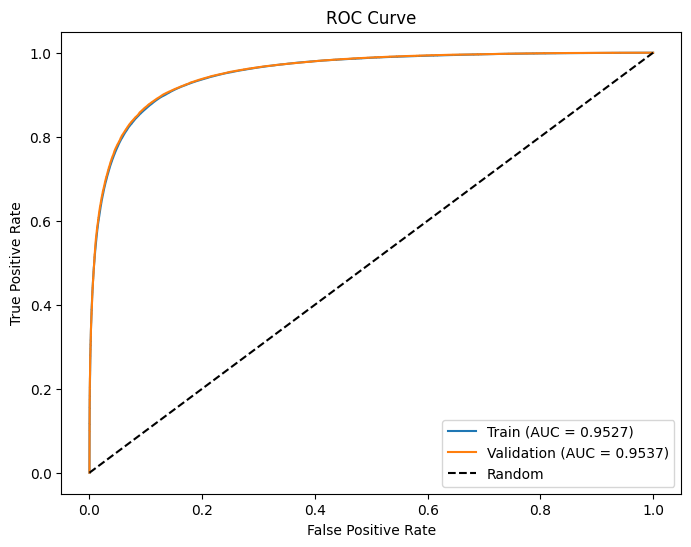

In [75]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Compute ROC curve and AUC for train
fpr_train, tpr_train, _ = roc_curve(y_train, train_probs, pos_label='Presence')
auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for validation
fpr_val, tpr_val, _ = roc_curve(y_valid, val_probs, pos_label='Presence')
auc_val = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})')
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## submission code

In [76]:
tst_df = pd.read_csv(path/'test.csv')

In [77]:
tst_df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.80,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.00,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.00,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.90,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.80,2,0,7


In [78]:
len(tst_df)

270000

In [60]:
tst_df.isna().sum()

id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
dtype: int64

In [84]:
preds = model.predict_proba(tst_df[cat_cols + cont_cols])[:,1]

In [85]:
preds.shape

(270000,)

In [87]:
preds.squeeze()

array([0.8955659 , 0.00494145, 0.98942569, ..., 0.05195947, 0.25232796,
       0.02671106], shape=(270000,))

In [ ]:
preds[:5]

In [88]:
tst_df['Heart Disease'] = preds.squeeze()
sub_df = tst_df[['id','Heart Disease']]
sub_df.to_csv('baseline_submission_simplelogistic.csv', index=False)